# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

map@k благополучно скопипащен отсюда

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

In [26]:
def apk(actual, predicted, k=10):

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [5]:
#def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        for i in range(self.n_users):
            rec = self.recommend(i)
            test_preds += [rec]
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]


## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    #pear_vec = np.ones(len(ratings))
    #for i in range(len(ratings)): 
    #    rat = ratings[i]
    #    denom = math.sqrt(sum(rat) * sum(user_vector))
    #    nom = sum(rat * user_vector)
    #   pears = nom/denom
    #    pear_vec[i] = pears
    #return(pear_vec)
    return np.array(list(
        r @ user_vector / (np.sqrt(r @ r * user_vector @ user_vector)) for r in ratings))
        


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return np.array(list(
        len(np.where((r > 0) & (user_vector > 0))[0]) /
        len(np.where((r > 0) | (user_vector > 0))[0])
            for r in ratings))

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [80]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)


        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        jaccard_users = self.similarity_func(self.R, user_vector)
        
        return jaccard_users

    def recommend(self, uid: int):
        sim_vec = self.similarity(self.R[uid])  #Находим вектор схожести всех остальных юзеров с нашим юзером uid
        ind_vec = np.where(sim_vec > self.alpha)[0] #Находим индексы юзеров, для которых схожесть больше порога альфа
        ind_vec = ind_vec[ind_vec != uid] #Удаляем из вектора индексов изначального юзера
        r_at_sim = sim_vec[ind_vec] @ self.R[ind_vec]
        rec_ind_desc = np.argsort(-r_at_sim)
        return rec_ind_desc

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [32]:
rec_jaccard = User2User(train_ratings, jaccard)
pred_jaccard = rec_jaccard.get_test_recommendations(50)

In [119]:
rec_pearson = User2User(train_ratings, pearson)
pred_pearson = rec_pearson.get_test_recommendations(50)

In [117]:
pred_random = np.array(list(np.random.choice(ratings['trackId'].unique(), 50) for _ in test_users))

In [121]:
mapk_jaccard = np.zeros(50)
mapk_pearson = np.zeros(50)
mapk_random = np.zeros(50)
for j in range(1, 51):
    print(j)
    mapk_jaccard[j-1] = mapk(test_relevant, pred_jaccard, j)
    mapk_pearson[j-1] = mapk(test_relevant, pred_pearson, j)
    mapk_random[j-1] = mapk(test_relevant, pred_random, j)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


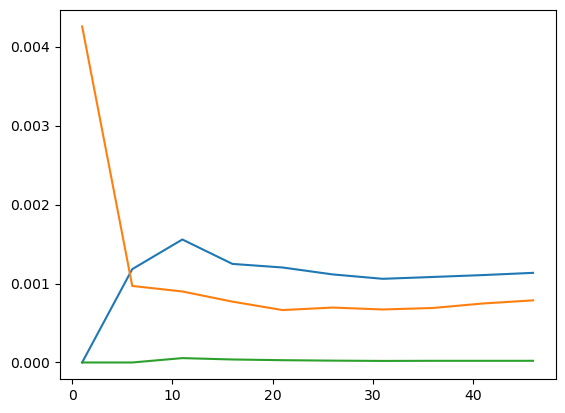

In [123]:
plt.plot(np.array([1, 6, 11, 16, 21, 26, 31, 36, 41, 46]), mapk_jaccard[::5])
plt.plot(np.array([1, 6, 11, 16, 21, 26, 31, 36, 41, 46]), mapk_pearson[::5])
plt.plot(np.array([1, 6, 11, 16, 21, 26, 31, 36, 41, 46]), mapk_random[::5])

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [82]:
from scipy.sparse import csr_matrix, find

def pearson_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    uv_reshaped = user_vector.reshape(-1, 1)
    return np.array(list(
        ((r @ uv_reshaped / (np.sqrt(
            (r @ r.reshape(-1, 1)) *
            (user_vector @ uv_reshaped)))).sum() for r in ratings)))

def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    return np.array(list(
        len(np.intersect1d(find(r)[1], find(user_vector)[1])) /
        len(find(r + user_vector > 0)[0])
            for r in ratings))

class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)
        self.R = csr_matrix(self.R)

u2u = User2UserSparse(train_ratings, pearson_sparse)
result_p_sp = u2u.get_test_recommendations(10)

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [83]:
user_id = np.random.randint(0, u2u.n_users)

In [84]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
263,M,['The Cure']
264,A Forest,['The Cure']
265,Play For Today,['The Cure']
616,Three Imaginary Boys,['The Cure']
617,Fire In Cairo,['The Cure']
647,"Valse in C sharp minor, Op. 64, No. 2","['Eugen Cicero', 'Фридерик Шопен']"
665,Johnny B. Goode,['Chuck Berry']
1151,Other Voices,['The Cure']
1808,Как остаться Человеком,['Distemper']
1809,На Рассвете,['Distemper']


In [85]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
59076,Я смотрю на них: 10 лет спустя,['Тараканы!']
65962,Just Dance,"['EQRIC', 'ISAEV', 'Britt Lari']"
59910,Ни много ни мало,['Boulevard Depo']
58220,Секрет,['ФРЕНДЗОНА']
57590,Clocks,"['Ian Storm', 'Ron van den Beuken']"
62242,Cause I'm God Girl,"['HyunA', 'Il Hoon Jung', 'Jung Ilhoon']"
61487,Gandagana,['Edo Yag']
61408,Ангелы здесь больше не живут,['Ульяна Karakoz']
61742,Имя твоё,['Колизей']
63679,Не я,['Kamazz']


In [86]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
62612,Забор,['Монгол Шуудан']
62818,С какой стати?,"['Ksenon', 'XBRO']"
63798,Лучшая роль,['Включай Микрофон!']
64046,Всем счастья,['Главная Роль']
64152,Метафизика,"['Anacondaz', 'Заточка']"
64683,I WANNA BE YOUR SLAVE,['Måneskin']
64763,"Сделай что-нибудь больше, чем просто хайп",['Distemper']
65142,Я никогда не стану феминисткой,['Nodahsa']
66627,"Купи, папа",['Каста']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

$$\nabla L_{p_u} = 2\sum_{(u, i) \in R}(\langle p_u, q_i \rangle - r_{ui}) * \langle p_u, q_u \rangle'_{pu} + 2\lambda p_u = $$

$$\nabla L_{p_u} = 2\sum_{(u, i) \in R}(p_u^T q_i - r_{ui}) * q_i + 2\lambda p_u = $$ 

$$ \nabla_{p_u} L = 2\sum\limits_i (p_u^Tq_i^2 - r_{ui}q_i) + 2\lambda p_u$$
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$
$$\nabla L_{q_i} = 2\sum_{(u, i) \in R}(\langle p_u, q_i \rangle - r_{ui}) * \langle p_u, q_u \rangle'_{qi} + 2\lambda q_i = $$

$$\nabla L_{q_i} = 2\sum_{(u, i) \in R}(q_i^Tp_u  - r_{ui}) * p_u + 2\lambda q_i = $$ 

$$ \nabla_{q_i} L = 2\sum\limits_i (q_i^Tp_u^2 - r_{ui}p_u) + 2\lambda q_i$$

$$
p_{u\ new} \quad = p_u - 2\eta(p_u^Tq_i^2 - r_{ui}q_i + \lambda p_u)$$

$$
q_{i\ new} \quad = q_i - 2\eta(q_i^Tp_u^2 - r_{ui}p_u + \lambda q_i)$$

$$$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ

L = 

\\
**ALS:**

Ответ:
$$\nabla_{p_u}(\sum_{(u, i) \in R}(r_{ui} - \hat{r}_{ui})^2) = \nabla_{p_u}2(\sum_{(u, i) \in R}(r_{ui} - \langle p_u, q_u \rangle^2) = 0 $$
$$\sum_ir_{ui}q_i - \sum q_i q_i^T p_u = 0$$
    $$p_u = (\sum q_i q_i^T)^{-1}\sum r_{ui}q_i$$
$$q_i = (\sum p_u p_u^T)^{-1}\sum r_{ui} p_u$$



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [77]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                u = np.random.randint(0, self.n_users)
                i = np.random.randint(0, self.n_items)
                p = self.P[u]
                q = self.Q[i]
                scal_multip = p @ q
                self.P[u] = p - 2 * self.lr * (scal_multip * q - self.R[u][i] * q + self.lamb * p)
                self.Q[i] = q - 2 * self.lr * (scal_multip * p - self.R[u][i] * p + self.lamb * q)
    

            elif self.mode == 'als':
                RQ = self.R @ self.Q
                for u in range(self.n_users):
                    relevant_items = train_ratings.trackId[train_ratings.userId == u]
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RQ[u]

                RP = self.R.T @ self.P
                for i in range(self.n_items):
                    relevant_users = train_ratings.userId[train_ratings.trackId == i]
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RP[i]

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [78]:
model = HiddenVars(train_ratings, dim = 256, mode = 'als')



In [79]:
model.fit()
model.get_test_recommendations(10)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
model = HiddenVars(train_ratings, dim = 256, mode = 'sgd')


In [23]:
model.fit()
model.get_test_recommendations(10)


  0%|          | 0/5 [00:00<?, ?it/s]

array([[20531, 22551, 49929, ...,  4757, 32353, 40347],
       [45698, 57838, 30785, ..., 66163, 28924, 33746],
       [ 1040, 54876, 12579, ..., 18400, 25598, 23273],
       ...,
       [20540, 18367,    59, ..., 19770, 56149, 61815],
       [60900,  3983, 40728, ..., 50804, 53894, 32429],
       [20221, 11001,   331, ..., 59154, 15737, 58661]])

Мне стало если честно страшно перебирать вообще все варианты, поэтому для подбора k и dim я перебираю все (как я думаю рациональные) варианты и рисую графики, а потом типа как жадный алгоритм беру самое лучшее и считаю что остается подобрать для этого лучшего самое классное количество итераций))

In [35]:
mapk_dims = []
for j in [10, 20, 30, 40, 50]:
    for i in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        print(i)
        model = HiddenVars(train_ratings, dim = i, mode = 'sgd')
        model.fit(1000)
        recs = model.get_test_recommendations(j)
        mapk_dims.append(mapk(test_relevant, recs, j))


4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

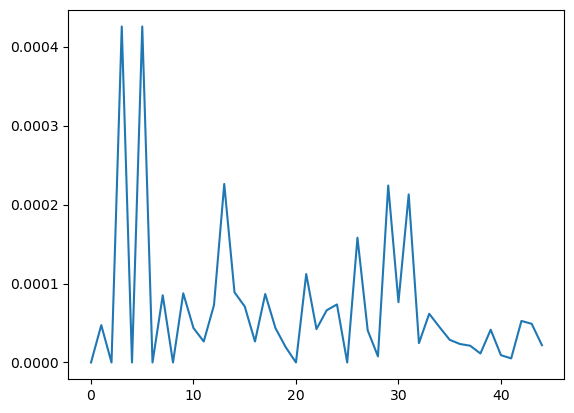

In [38]:
plt.plot(range(45), mapk_dims)

На этом абсолютно гениальном графике который могу понять только я можно увидить, что пики у нас где то на первых итерациях были достигнуты, поэтому сейчас я обучу на k = 20, 30 и посмотрю на каком dim самые лучшие map @k

4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

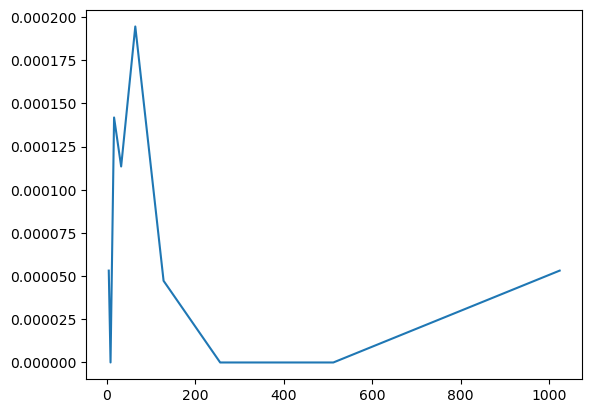

In [40]:
mapk_dims = []
for i in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    print(i)
    model = HiddenVars(train_ratings, dim = i, mode = 'sgd')
    model.fit(1000)
    recs = model.get_test_recommendations(10)
    mapk_dims.append(mapk(test_relevant, recs, 10))
plt.plot([4, 8, 16, 32, 64, 128, 256, 512, 1024], mapk_dims)



4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

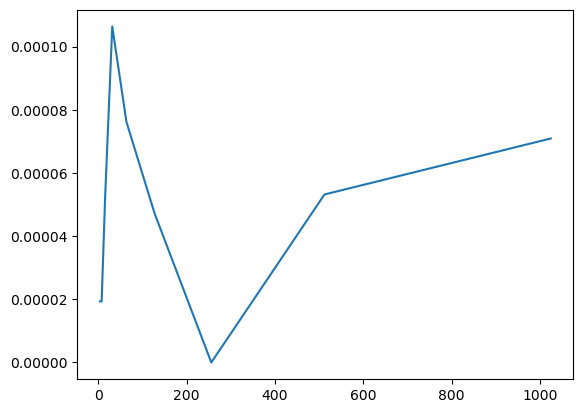

In [39]:
mapk_dims = []
for i in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    print(i)
    model = HiddenVars(train_ratings, dim = i, mode = 'sgd')
    model.fit(1000)
    recs = model.get_test_recommendations(20)
    mapk_dims.append(mapk(test_relevant, recs, 20))
plt.plot([4, 8, 16, 32, 64, 128, 256, 512, 1024], mapk_dims)


4


  0%|          | 0/1000 [00:00<?, ?it/s]

8


  0%|          | 0/1000 [00:00<?, ?it/s]

16


  0%|          | 0/1000 [00:00<?, ?it/s]

32


  0%|          | 0/1000 [00:00<?, ?it/s]

64


  0%|          | 0/1000 [00:00<?, ?it/s]

128


  0%|          | 0/1000 [00:00<?, ?it/s]

256


  0%|          | 0/1000 [00:00<?, ?it/s]

512


  0%|          | 0/1000 [00:00<?, ?it/s]

1024


  0%|          | 0/1000 [00:00<?, ?it/s]

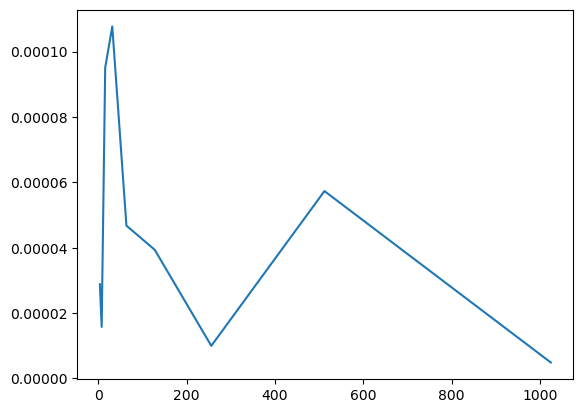

In [41]:
mapk_dims = []
for i in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    print(i)
    model = HiddenVars(train_ratings, dim = i, mode = 'sgd')
    model.fit(1000)
    recs = model.get_test_recommendations(30)
    mapk_dims.append(mapk(test_relevant, recs, 30))
plt.plot([4, 8, 16, 32, 64, 128, 256, 512, 1024], mapk_dims)



ну очевидно что самые лучшие dim при любых раскладах по k это где то 64

1000


  0%|          | 0/1000 [00:00<?, ?it/s]

1500


  0%|          | 0/1500 [00:00<?, ?it/s]

5000


  0%|          | 0/5000 [00:00<?, ?it/s]

10000


  0%|          | 0/10000 [00:00<?, ?it/s]

50000


  0%|          | 0/50000 [00:00<?, ?it/s]

100000


  0%|          | 0/100000 [00:00<?, ?it/s]

1000000


  0%|          | 0/1000000 [00:00<?, ?it/s]

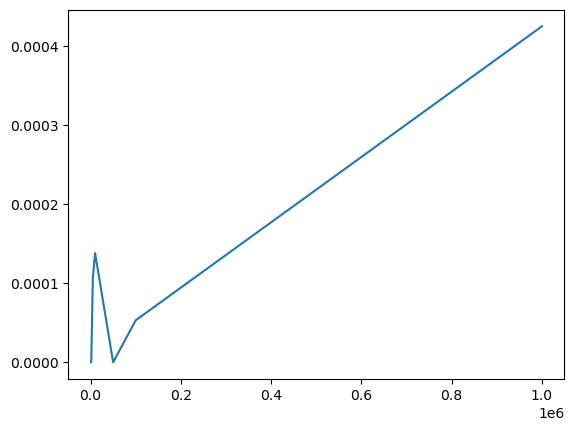

In [88]:
mapk_dims = []
for i in [1000, 1500, 5000, 10000, 50000, 100000, 1000000]:
    print(i)
    model = HiddenVars(train_ratings, dim = 64, mode = 'sgd')
    model.fit(i)
    recs = model.get_test_recommendations(10)
    mapk_dims.append(mapk(test_relevant, recs, 10))
plt.plot([1000, 1500, 5000, 10000, 50000, 100000, 1000000], mapk_dims)




In [89]:
model = HiddenVars(train_ratings, dim = 64, mode = 'sgd')
model.fit(1000000)
recs = model.get_test_recommendations(10)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [90]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [91]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
66922,Одна,['Alisha'],0.483683
12317,Песенка первоклассника,['Алла Пугачёва'],0.478787
49673,Воином,"['Намо Миниган', 'Miyagi & Эндшпиль']",0.478015
408,Ridin',"['Chamillionaire', 'SWAY']",0.463774
36051,Следи за собой,['Виктор Цой'],0.459762
21335,Love In Song,"['Paul McCartney', 'Wings']",0.459588
61210,Falling,"['Living In Fiction', 'Trying Times']",0.452423
13956,How Many Loves,['Naomi'],0.447948
39701,Мама-анархия,['КИНО'],0.442347
